# Обучение с подкреплением на примере задачи о многоруком бандите

# Обучение с подкреплением



## Определение

**Обучение с подкреплением** — один из способов машинного обучения, в ходе которого испытуемая система (агент) обучается, взаимодействуя с некоторой средой. Откликом среды на принятые решения агента являются сигналы подкрепления, поэтому такое обучение является частным случаем обучения с учителем, но учителем является среда или её модель.

**Среда** обычно формулируется как марковский процесс принятия решений с конечным множеством состояний, и в этом смысле алгоритмы обучения с подкреплением тесно связаны с динамическим программированием. Вероятности выигрышей и перехода состояний в МППР обычно являются величинами случайными, но стационарными в рамках задачи.

## Формальная постановка задачи

С формальной точки зрения модель обучения с подкреплением состоит из множества состояний среды $S$, множества возможных действий $A$ и множества наград $R$.

В произвольный момент времени $t$ агент характеризуется состоянием $s_t∈S$ и множеством возможных действий $A(s_t)$. Выбирая действие $a∈A(s_t)$, он переходит в состояние $s_t+1$ и получает награду $r_t$. Основываясь на таком взаимодействии с окружающей средой, агент, обучающийся с подкреплением, должен выработать стратегию $π:S→A$, которая максимизирует величину $R=r_0+r_1+...+r_n$ в случае МППР, имеющего терминальное состояние, или величину $R=∑_tγ^tr_t$, для МППР без терминальных состояний (где $0≤γ≤1$ — дисконтирующий множитель для "предстоящего выигрыша").

Таким образом, обучение с подкреплением особенно хорошо подходит для решения задач, связанных с выбором между долгосрочной и краткосрочной выгодой (exploration vs exploitation).

## Взаимодействие агента со средой

Взаимодействие агента со средой строится следующим образом:

* Агент инициализирует начальную стратегию для первого состояния среды
* На каждом шаге:
 * Агент выбирает одно из доступных действий
 * Среда генерирует награду и новое состояние
 * Агент корректирует стратегию

Об итоговой эффективности агента можно судить по накопленной в ходе всего взаимодействия со средой награде.

# Задача о многоруком бандите

## Описание

В задаче о многоруком бандите роль среды выполняет метафорический игровой автомат, который имеет несколько ручек. Когда агент дергает за одну из ручек, ему выдается награда, сгенерированная случайным образом в соответствии с неким распределением, которое агенту неизвестно. Причем данное распределение для каждой ручки может отличаться. Цель агента - за определенное число операций накопить максимально возможную награду.

## Формальная постановка задачи

$A$ — множество возможных действий (ручек автомата),

$p_a(r)$ — неизвестное распределение награды $r∈R∀a∈A$,

$π_t(a)$ — стратегия агента в момент $t∀a∈A$.

На каждом шаге $t∈1...T$ агент выбирает ручку $a_t∼π_t(a)$, после чего среда генерирует награду $r_t∼p_{a_t}(r)$. На основании награды агент корректирует стратегию $π_{t+1}(a)$.

Необходимо максимизировать $Q_t(a)=∑^t_{i=1}\frac{r_i[a_i=a]}{∑^t_{i=1}[a_i=a]}→max$, т.е. среднюю награду за $t$ итераций.

Из-за того, что награды - это случайные величины с неизвестным распределением, будем оптимизировать математические ожидания наград $\frac{1}{T}∑^T_{t=1}r_t$.

## Реализация основных подходов

Перед началом работы импортируем необходимые библиотеки.

In [135]:
import numpy as np;
import math;
import matplotlib.pyplot as plt;
%matplotlib inline

### Случайный выбор

Большая часть реализации будет одинаковой для всех стратегий, которые будут описаны в этом туториале. Поэтому создадим родительский класс, от которого будут наследоваться все остальные алгоритмы.

Агент в этом случае будет на каждом шаге дергать случайную ручку. Такое решение также понадобится нам в дальнейшем для сравнения эффективности разных подходов.

In [136]:
class Bandit:

    # В конструктор класса будем передавать количество ручек автомата (arms_num),
    # количество итераций - сколько раз будем выбирать ручку (iters_num) и
    # средние значения распределений наград (reward_distribution).
    def __init__(self, arms_num, iters_num, reward_distribution):
        self.arms_num = arms_num;
        self.iters_num = iters_num;

        # В качестве reward_distribution мы можем передать список или np.array средних значений распределений,
        # например [ 4, 6, 3 ],
        # либо что угодно, не являющееся списком - в таком случае средние значения будут
        # выбраны случайным образом из диапазона (2, 4).
        if type(reward_distribution) == list or type(reward_distribution).__module__ == np.__name__:
            self.reward_distribution = np.array(reward_distribution);
        else:
            self.reward_distribution = np.random.normal(3, 1, arms_num);

        # Текущая итерация.
        self.iters_count = 0;
        # Сколько раз была дернута каждая ручка.
        self.arms_pulled_count = np.zeros(arms_num);

        # Среднее значение полученной за все время награды.
        self.mean_reward = 0;
        # Среднее значение награды на каждой итерации.
        self.iters_mean_rewards = np.zeros(iters_num);
        # Среднее значение награды от каждой ручки.
        self.arms_mean_rewards = np.zeros(arms_num);


    # Пока будем каждый раз выбирать ручку случайным образом.
    def pull(self):
        return np.random.choice(self.arms_num);


    # Награда - случайное число с нормальным распределением с центром в reward_distribution[i].
    # Дисперсия равна единице, но при желании это значение можно поменять.
    def get_reward_from_arm(self, arm_to_pull):
        return np.random.normal(self.reward_distribution[arm_to_pull], 1);


    # Вспомогательная функция для увеличения счетчиков и обновления средних наград после выбора ручки.
    def update_state(self, arm_to_pull, reward):
        self.iters_count += 1;
        self.arms_pulled_count[arm_to_pull] += 1;

        self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.iters_count;
        self.arms_mean_rewards[arm_to_pull] = self.arms_mean_rewards[arm_to_pull] + (reward - self.arms_mean_rewards[arm_to_pull]) / self.arms_pulled_count[arm_to_pull];


    # Выбираем и дергаем ручку iters_num раз.
    def run(self):
        for i in range(self.iters_num):
            arm_to_pull = self.pull();

            reward = self.get_reward_from_arm(arm_to_pull);
            self.update_state(arm_to_pull, reward);

            self.iters_mean_rewards[i] = self.mean_reward;


    # Вспомогательная функция для зануления счетчиков и средних наград после выполнения алгоритма.
    # Нужно использовать перед повторным запуском алгоритма с теми же параметрами.
    def reset(self):
        self.iters_count = 0;
        self.arms_pulled_count = np.zeros(self.arms_num);
        self.mean_reward = 0;
        self.iters_mean_rewards = np.zeros(self.iters_num);
        self.arms_mean_rewards = np.zeros(self.arms_num);

Можно проверить, как будет вести себя алгоритм. В теории он должен дернуть каждую ручку примерно одинаковое количество раз.

In [167]:
bandit_random = Bandit(arms_num=5, iters_num=1000, reward_distribution='random');

bandit_random.run();

print("Arms pulled: " + str(bandit_random.arms_pulled_count));

Arms pulled: [195. 214. 213. 203. 175.]


### Жадная стратегия

На каждом шаге выбираем действие с максимальным математическим ожиданием.

После того, как агент дернет за первую ручку и получит награду, ожидаемый выигрыш первой ручки увеличится. Так как на каждом шаге агент выбирает ручку с максимальным ожидаемым выигрышем, он всегда будет дергать ту ручку, которую дернул первой.

Проблема этой стратегии заключается в том, что при неотрицательных наградах агент никогда не будет исследовать альтернативные опции, которые могли бы принести больший выигрыш. 

In [138]:
class Greedy_bandit(Bandit):

    def pull(self):
        if self.iters_count == 0:
            return np.random.choice(self.arms_num);
        else:
            return np.argmax(self.arms_mean_rewards);

Можно несколько раз запустить следующий блок, чтобы убедиться, что жадный агент всегда дергает одну и ту же ручку.

In [168]:
bandit_greedy = Greedy_bandit(5, 1000, 'random');

bandit_greedy.run();

print("Arms pulled: " + str(bandit_greedy.arms_pulled_count));

Arms pulled: [   0.    0. 1000.    0.    0.]


Жадный алгоритм часто дает результаты хуже, чем случайный. Несмотря на это, в $\frac{1}{A}$ случаев он будет выдавать лучший результат среди всех алгоритмов.

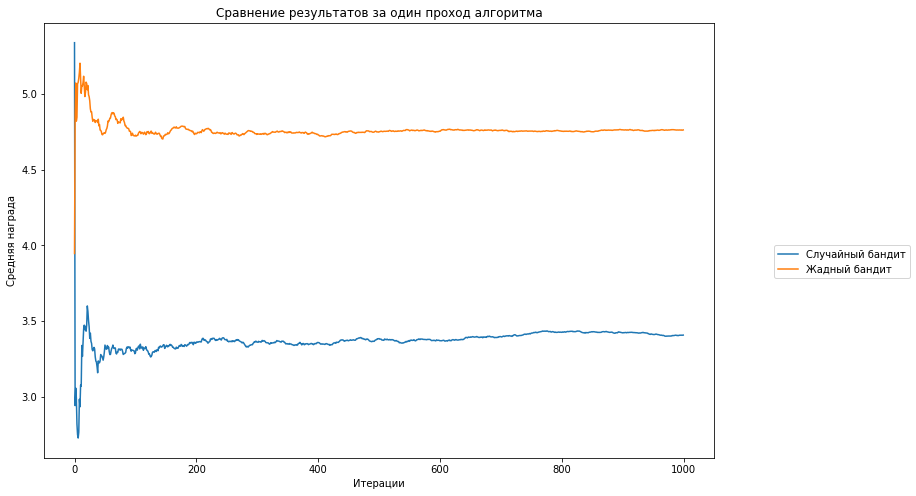

In [150]:
arms = 5;
iters = 1000;

bandit_random = Bandit(arms, iters, "random");
bandit_greedy = Greedy_bandit(arms, iters, bandit_random.reward_distribution.copy());

bandit_random.run();
bandit_greedy.run();

plt.figure(figsize=(12,8));
plt.plot(bandit_random.iters_mean_rewards, label="Случайный бандит");
plt.plot(bandit_greedy.iters_mean_rewards, label="Жадный бандит");
plt.legend(bbox_to_anchor=(1.3, 0.5));
plt.xlabel("Итерации");
plt.ylabel("Средняя награда");
plt.title("Сравнение результатов за один проход алгоритма");
plt.show();

Для того, чтобы уменьшить зашумленность результатов и определить истинную эффективность жадного подхода, можно усреднять результаты множества проходов алгоритма.

In [161]:
# Вспомогательная функция для получения усредненных результатов после нескольких проходов алгоритма
def get_mean_rewards_over_multiple_runs(bandit, runs):
    mean_rewards = np.zeros(bandit.iters_num);

    for i in range(runs):
        bandit.run();
        mean_rewards = mean_rewards + (bandit.iters_mean_rewards - mean_rewards) / (i + 1);
        bandit.reset();

    return mean_rewards;

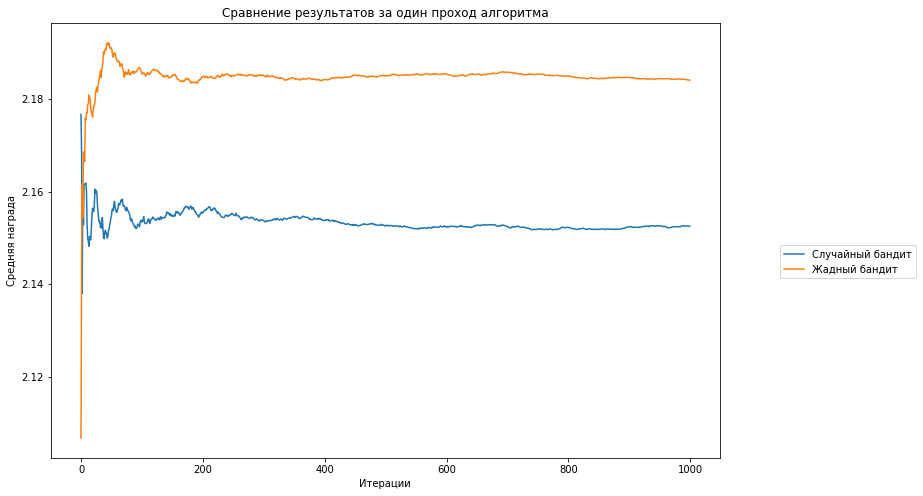

In [169]:
arms = 5;
iters = 1000;
runs = 1000;

bandit_random = Bandit(arms, iters, "random");
bandit_greedy = Greedy_bandit(arms, iters, bandit_random.reward_distribution.copy());

plt.figure(figsize=(12,8));
plt.plot(get_mean_rewards_over_multiple_runs(bandit_random, runs), label="Случайный бандит");
plt.plot(get_mean_rewards_over_multiple_runs(bandit_greedy, runs), label="Жадный бандит");
plt.legend(bbox_to_anchor=(1.3, 0.5));
plt.xlabel("Итерации");
plt.ylabel("Средняя награда");
plt.title("Сравнение результатов за 1000 проходов алгоритма");
plt.show();

### ϵ-Жадные стратегии

Для того, чтобы подтолкнуть жадную стратегию к исследованию альтернативных опций можно воспользоваться ϵ-жадным подходом.

Вводится дополнительный параметр $ϵ∈(0,1)$. На каждом шаге генерируем случайное число $p∈(0,1)$ и сравниваем $p$ и $ϵ$. Если $p<ϵ$, дергаем случайную ручку, иначе продолжаем придерживаться жадной стратегии.

In [170]:
class Epsilon_greedy_bandit(Bandit):

    def __init__(self, arms_num, iters_num, epsilon, reward_distribution):
        super().__init__(arms_num, iters_num, reward_distribution);
        self.epsilon = epsilon;


    def pull(self):
        p = np.random.rand();

        if self.iters_count == 0 or p < self.epsilon:
            return np.random.choice(self.arms_num);
        else:
            return np.argmax(self.arms_mean_rewards);

Нетрудно заметить, что чем больше ϵ, тем чаще агент исследует альтернативные опции.

In [190]:
bandit_0005 = Epsilon_greedy_bandit(5, 1000, 0.005, 'random');

bandit_0005.run();

print("eps = 0.005; Arms pulled: " + str(bandit_0005.arms_pulled_count));

bandit_01 = Epsilon_greedy_bandit(5, 1000, 0.1, 'random');

bandit_01.run();

print("eps = 0.1;   Arms pulled: " + str(bandit_01.arms_pulled_count));

eps = 0.005; Arms pulled: [  1.   0. 672. 325.   2.]
eps = 0.1;   Arms pulled: [ 18.  18. 926.  25.  13.]


Сравним эффективность ϵ-жадного подхода с уже известными нам моделями.

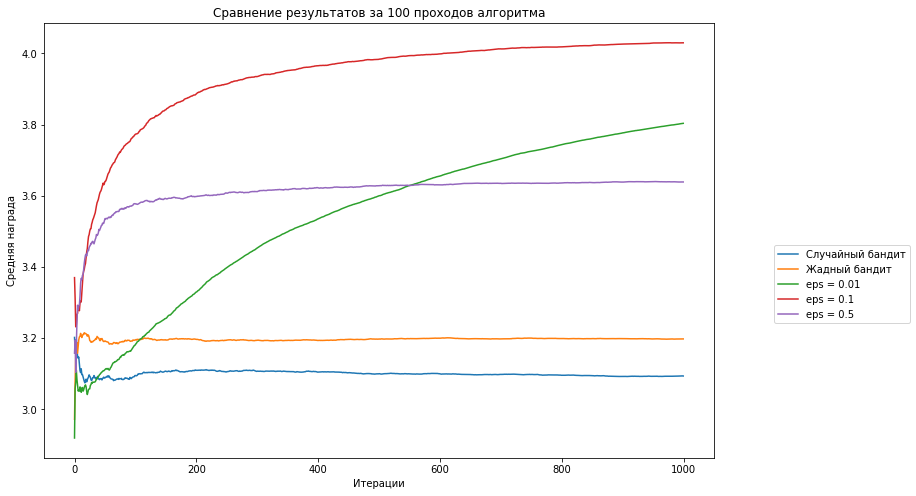

In [191]:
arms = 5;
iters = 1000;
runs = 100;

bandit_random = Bandit(arms, iters, "random");
bandit_greedy = Greedy_bandit(arms, iters, bandit_random.reward_distribution.copy());
bandit_eps_001 = Epsilon_greedy_bandit(arms, iters, 0.01 ,bandit_random.reward_distribution.copy());
bandit_eps_01 = Epsilon_greedy_bandit(arms, iters, 0.1 ,bandit_random.reward_distribution.copy());
bandit_eps_05 = Epsilon_greedy_bandit(arms, iters, 0.5 ,bandit_random.reward_distribution.copy());

plt.figure(figsize=(12,8));
plt.plot(get_mean_rewards_over_multiple_runs(bandit_random, runs), label="Случайный бандит");
plt.plot(get_mean_rewards_over_multiple_runs(bandit_greedy, runs), label="Жадный бандит");
plt.plot(get_mean_rewards_over_multiple_runs(bandit_eps_001, runs), label="eps = 0.01");
plt.plot(get_mean_rewards_over_multiple_runs(bandit_eps_01, runs), label="eps = 0.1");
plt.plot(get_mean_rewards_over_multiple_runs(bandit_eps_05, runs), label="eps = 0.5");
plt.legend(bbox_to_anchor=(1.3, 0.5));
plt.xlabel("Итерации");
plt.ylabel("Средняя награда");
plt.title("Сравнение результатов за 100 проходов алгоритма");
plt.show();

### Стратегия ϵ-Decay (убывающего ϵ)

Так как в постановке задачи распределения наград не меняются, можно заключить, что необходимость выбора уже исследованных ручек, дающих низкую награду, со временем убывает. Иными словами, мы хотим, чтобы агент чаще дергал за самую выгодную ручку, если распределения наград всех ручек уже примерно известны.

Один из вариантов реализации такого подхода - динамическое снижение значения ϵ с увеличением номера текущей итерации. В этом примере используется формула $ϵ=\frac{1}{1+t*\frac{1}{A}}$. Вместо $\frac{1}{A}$ можно использовать другую константу для управления скоростью снижения ϵ.

Одним из преимуществ ϵ-Decay стратегии является то, что начальное значение ϵ можно не подбирать самостоятельно.

In [192]:
class Epsilon_decay_bandit(Bandit):

    def pull(self):
        p = np.random.rand();
        epsilon = 1 / (1 + self.iters_count / self.arms_num);

        if self.iters_count == 0 or p < epsilon:
            return np.random.choice(self.arms_num);
        else:
            return np.argmax(self.arms_mean_rewards);

Сравним эффективность ϵ-стратегий.

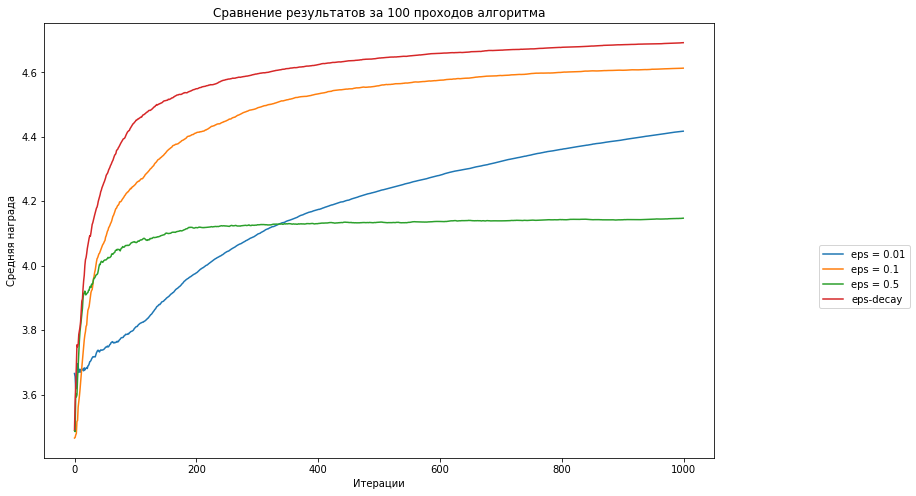

In [193]:
arms = 5;
iters = 1000;
runs = 100;

bandit_eps_001 = Epsilon_greedy_bandit(arms, iters, 0.01, "random");
bandit_eps_01 = Epsilon_greedy_bandit(arms, iters, 0.1, bandit_eps_001.reward_distribution.copy());
bandit_eps_05 = Epsilon_greedy_bandit(arms, iters, 0.5, bandit_eps_001.reward_distribution.copy());
bandit_eps_decay = Epsilon_decay_bandit(arms, iters, bandit_eps_001.reward_distribution.copy());

plt.figure(figsize=(12,8));
plt.plot(get_mean_rewards_over_multiple_runs(bandit_eps_001, runs), label="eps = 0.01");
plt.plot(get_mean_rewards_over_multiple_runs(bandit_eps_01, runs), label="eps = 0.1");
plt.plot(get_mean_rewards_over_multiple_runs(bandit_eps_05, runs), label="eps = 0.5");
plt.plot(get_mean_rewards_over_multiple_runs(bandit_eps_decay, runs), label="eps-decay");
plt.legend(bbox_to_anchor=(1.3, 0.5));
plt.xlabel("Итерации");
plt.ylabel("Средняя награда");
plt.title("Сравнение результатов за 100 проходов алгоритма");
plt.show();

### Softmax стратегия

Особенность Softmax стратегии состоит в том, что при помощи функции Softmax $\frac{e^{Q_t(a)}}{Σ_{bϵA}e^{Q_t(b)}}$ мы находим вероятность выбора рук таким образом, что у рук, дававших большие награды в прошлом, большая вероятность выбора, чем у остальных.

Также можно ввести параметр $τ$ следующим образом: $\frac{e^{\frac{Q_t(a)}{τ}}}{Σ_{bϵA}e^{\frac{Q_t(b)}{τ}}}$. Тогда при $τ→∞$ стратегия стремится к равномерной, то есть softmax будет меньше зависеть от значения выигрыша и выбирать действия более равномерно (exploration). При $τ→0$ стратегия стремится к жадной, то есть алгоритм будет больше ориентироваться на известный средний выигрыш действий (exploitation).

В данном примере параметр $τ$ не используется (равен 1).

In [194]:
class Softmax_bandit(Bandit):

    def get_arms_probabilities(self, arms_mean_rewards):
        arms_probabilities = np.zeros_like(arms_mean_rewards);

        for i in range(len(arms_mean_rewards)):
            arms_probabilities[i] = np.exp(arms_mean_rewards[i]) / np.sum(np.exp(arms_mean_rewards));
        
        return arms_probabilities;
    

    def pull(self):
        arms_probabilities = self.get_arms_probabilities(self.arms_mean_rewards);

        return np.random.choice(self.arms_num, p=arms_probabilities);

### UCB стратегия

Наиболее часто используемый подход для решения задачи о многоруком бандите.
Агент сначала дергает каждую ручку по одному разу, а потом на каждом шаге выбирает ту руку, у которой верхняя граница доверительного интервала (UCB - upper confidence bound) награды $Q_t(a)+\sqrt{\frac{2ln(t)}{P_a}}$ (где $P_a$ - то, сколько раз агент дернул конкретную ручку) принимает максимальное значение.

На практике это означает, что при выборе ручки учитывается то, насколько много агент уже знает о ее распределении - предпочтение отдается малоизученным ручкам.

В отличие от предыдущих алгоритмов, UCB не использует в своей работе ни случайные числа для выбора действия, ни параметры, которыми можно влиять на его работу.

In [197]:
class UCB_bandit(Bandit):

    def pull(self):
        arms_not_pulled = np.where(self.arms_pulled_count == 0)[0];

        if arms_not_pulled.size > 0:
            return arms_not_pulled[0];
        else:
            arms_scores = np.zeros(self.arms_num);

            for i in range(len(arms_scores)):
                arms_scores[i] = self.arms_mean_rewards[i] + math.sqrt(2 * math.log(self.iters_count) / self.arms_pulled_count[i]);
            
            return np.argmax(arms_scores);

Сравним эффективность стратегий ϵ-Decay, Softmax и UCB.

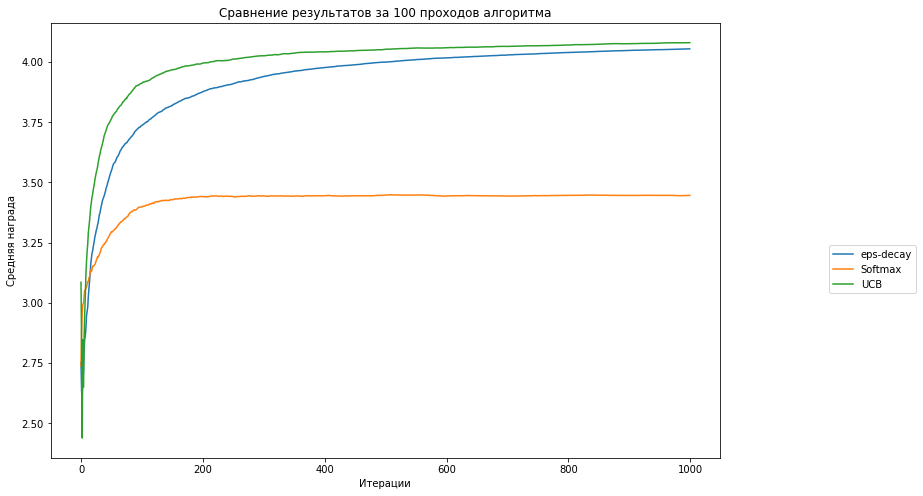

In [198]:
arms = 5;
iters = 1000;
runs = 100;

bandit_eps_decay = Epsilon_decay_bandit(arms, iters, "random");
bandit_softmax = Softmax_bandit(arms, iters, bandit_eps_decay.reward_distribution.copy());
bandit_ucb = UCB_bandit(arms, iters, bandit_eps_decay.reward_distribution.copy());

plt.figure(figsize=(12,8));
plt.plot(get_mean_rewards_over_multiple_runs(bandit_eps_decay, runs), label="eps-decay");
plt.plot(get_mean_rewards_over_multiple_runs(bandit_softmax, runs), label="Softmax");
plt.plot(get_mean_rewards_over_multiple_runs(bandit_ucb, runs), label="UCB");
plt.legend(bbox_to_anchor=(1.3, 0.5));
plt.xlabel("Итерации");
plt.ylabel("Средняя награда");
plt.title("Сравнение результатов за 100 проходов алгоритма");
plt.show();

Можно заметить, что эффективность UCB стратегии превосходит ϵ-Decay, которая была самой результативной из ранее рассмотренных. 

## Сравнение всех стратегий

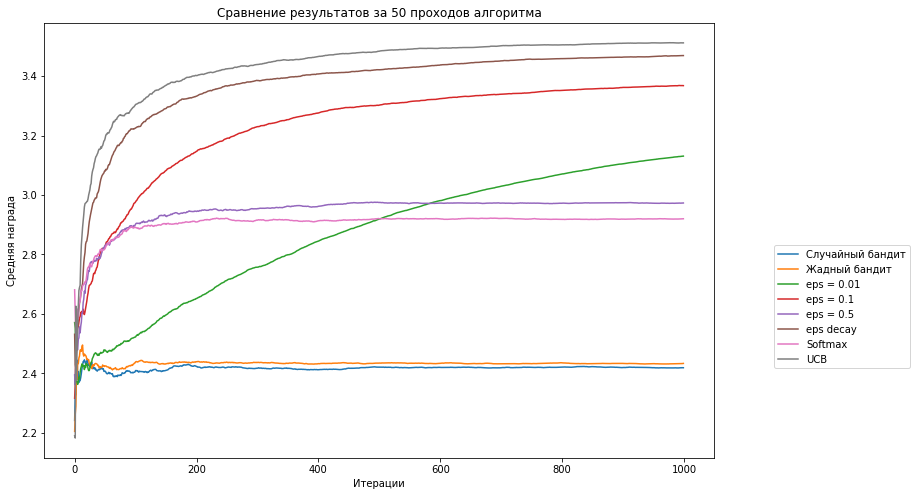

In [202]:
# Результат может быть зашумленным. Для более гладких результатов можно увеличить
# количество проходов алгоритма (runs). Это повлияет на скорость работы.
arms = 5;
iters = 1000;
runs = 50;

bandit_random = Bandit(arms, iters, "random");
bandit_greedy = Greedy_bandit(arms, iters, bandit_random.reward_distribution.copy());
bandit_eps_001 = Epsilon_greedy_bandit(arms, iters, 0.01 ,bandit_random.reward_distribution.copy());
bandit_eps_01 = Epsilon_greedy_bandit(arms, iters, 0.1 ,bandit_random.reward_distribution.copy());
bandit_eps_05 = Epsilon_greedy_bandit(arms, iters, 0.5 ,bandit_random.reward_distribution.copy());
bandit_eps_decay = Epsilon_decay_bandit(arms, iters, bandit_random.reward_distribution.copy());
bandit_softmax = Softmax_bandit(arms, iters, bandit_random.reward_distribution.copy());
bandit_ucb = UCB_bandit(arms, iters, bandit_random.reward_distribution.copy());

plt.figure(figsize=(12,8));
plt.plot(get_mean_rewards_over_multiple_runs(bandit_random, runs), label="Случайный бандит");
plt.plot(get_mean_rewards_over_multiple_runs(bandit_greedy, runs), label="Жадный бандит");
plt.plot(get_mean_rewards_over_multiple_runs(bandit_eps_001, runs), label="eps = 0.01");
plt.plot(get_mean_rewards_over_multiple_runs(bandit_eps_01, runs), label="eps = 0.1");
plt.plot(get_mean_rewards_over_multiple_runs(bandit_eps_05, runs), label="eps = 0.5");
plt.plot(get_mean_rewards_over_multiple_runs(bandit_eps_decay, runs), label="eps decay");
plt.plot(get_mean_rewards_over_multiple_runs(bandit_softmax, runs), label="Softmax");
plt.plot(get_mean_rewards_over_multiple_runs(bandit_ucb, runs), label="UCB");
plt.legend(bbox_to_anchor=(1.3, 0.5));
plt.xlabel("Итерации");
plt.ylabel("Средняя награда");
plt.title("Сравнение результатов за" + runs + "проходов алгоритма");
plt.show();

Из графика видно, что из рассмотренных подходов к решению задачи о многоруком бандите метод UCB оказался самым эффективным.

## Применение задачи о многоруком бандите

Сетевая маршрутизация

Маршрутизация - это процесс выбора пути для трафика в сети, такой как телефонные сети или Интернет. Выделение каналов нужным пользователям, чтобы общая пропускная способность была максимальной, можно сформулировать как задачу о многоруком бандите.

Реклама в интернете

Целью рекламной кампании является получение максимального дохода от показа рекламы. Рекламодатель получает доход каждый раз, когда пользователь нажимает на предложение. Как и в случае с задачей о многоруком бандите, существует компромисс между исследованием, цель которого состоит в сборе информации об эффективности объявления с использованием рейтинга кликов, и экслпуатацией, когда мы показываем объявление, которое до сих пор давало наилучшие результаты.

# Источники


https://en.wikipedia.org/wiki/Reinforcement_learning

https://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81_%D0%BF%D0%BE%D0%B4%D0%BA%D1%80%D0%B5%D0%BF%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC

https://www.analyticsvidhya.com/blog/2018/09/reinforcement-multi-armed-bandit-scratch-python/

https://towardsdatascience.com/multi-armed-bandits-and-reinforcement-learning-dc9001dcb8da